### Questions

- Display routine ?
- qatdisplay uses global variables ?
- Why not dictionnary for res ?
- Why not Hadamard in Rk ?
- epsilon1: how can the number of observations to get something different from 0 not scale with the size of the space ?
- epsilon2: can we really neglect the term that looks like epsilon1 ?

### Typos in the documentation

- QRoutine.new_wires: additional (line 7)

In [212]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from qat.lang.AQASM import *
from qat.core import *
from qat.qpus import get_default_qpu
from qat.fermion.impurity.hamiltonians import make_anderson_model
from qat.fermion.hamiltonians import Hamiltonian

##### Transform to spin Hamiltonian

In [177]:
def transform_to_jw_basis(fermion_hamiltonian):
    """Transform to Jordan-Wigner (JW) basis
    Args:
        fermion_hamiltonian (Hamiltonian or ElectronicStructureHamiltonian): the
            fermionic hamiltonian
    Returns:
        Hamiltonian: the same hamiltonian, in JW spin representation
    """

    nqbits = fermion_hamiltonian.nbqbits
    spin_hamiltonian = Hamiltonian(
        nqbits, [], constant_coeff=fermion_hamiltonian.constant_coeff, do_clean_up=False
    )
    for term in fermion_hamiltonian.terms:
        cur_ham = Hamiltonian(nqbits, [], constant_coeff=term.coeff)
        for op, qb in zip(term.op, term.qbits):
            mini_ham = Hamiltonian(nqbits, [])
            qbits = list(range(qb + 1))

            st = "Z" * (qb) + "X"
            mini_ham.add_term(Term(0.5, st, qbits))

            st = "Z" * (qb) + "Y"
            sign = -1 if op == "C" else 1
            mini_ham.add_term(Term(1j * sign * 0.5, st, qbits))

            cur_ham = cur_ham * mini_ham
        spin_hamiltonian += cur_ham
    spin_hamiltonian.clean_up()
    return spin_hamiltonian

# Hardware efficient ansatz

The parameter $\theta$ has a number of coordinates `n_qubits + n_layers * (2 * n_qubits - 2)`

We assume that `n_qubits` is even

In [15]:
def HEA(n_qubits, n_layers, theta):
        
    routine = QRoutine()
    
    if n_qubits % 2 == 1:
        raise ValueError("The number of qubits should be even")
    
    routine.new_wires(n_qubits)
    
    for k in range(n_qubits):
        routine.apply(RY(theta[k]), k)
    
    for n in range(n_layers):
        
        # First CNOT layer
        for k in range(n_qubits // 2):
            routine.apply(CNOT, 2 * k, 2 * k + 1)
        
        # First RY layer
        for k in range(n_qubits):
            routine.apply(RY(theta[n_qubits + n * (2 * n_qubits - 2) + k]), k)
        
        # Second CNOT layer
        for k in range(n_qubits // 2 - 1):
            routine.apply(CNOT, 2 * k + 1, 2 * k + 2)
        
        # Second RY layer
        for k in range(n_qubits - 2):
            routine.apply(RY(theta[2 * n_qubits + n * (2 * n_qubits - 2) + k]), k + 1)
    
    return routine

##### We take a look at the ansatz and its inverse

In [16]:
n_qubits = 4
n_layers = 2

prog = Program()
reg = prog.qalloc(n_qubits)
U = HEA(n_qubits, n_layers, np.array(range(n_qubits + n_layers * (2 * n_qubits - 2)), float))
U(reg)
U.dag()(reg)

circ = prog.to_circ()

%qatdisplay circ --svg

##### We check that they are indeed the inverse of each other

In [17]:
qpu = get_default_qpu()

job = circ.to_job(nbshots=0)
res = qpu.submit(job)
for sample in res:
    print(sample.state, sample.probability, sample.amplitude)

|0000> 0.9999999999999991 (0.9999999999999996+0j)


# Functions to minimize

### Construction of $\epsilon_1$ and $\epsilon_2$

Since $\epsilon_1$ and $\epsilon_2$ are the same functions for a different theta on the right ($\theta_{n - 1}$ or $\theta_{n - 2}$), we group them in a single function `epsilon12`.

In [18]:
def epsilon12(theta, theta_last, nb_shots, n_qubits, n_layers):
        
    qpu = get_default_qpu()
    
    prog = Program()
    reg = prog.qalloc(n_qubits)
    
    U1 = HEA(n_qubits, n_layers, theta_last)
    U2 = HEA(n_qubits, n_layers, theta)
    
    U1(reg)
    U2.dag()(reg)
    
    circ = prog.to_circ()
        
    job = circ.to_job(nbshots = nb_shots)
    res = qpu.submit(job)
    
    # We look for the probability of 0
    for sample in res:
        if sample._state == 0:
            return sample.probability
    
    return 0

In [295]:
np.random.seed(0)
epsilon12(np.random.rand(100), np.random.rand(100), 100000, 10, 5)

0.0308

In [ ]:
0.03112730978126085

### Construction of $\epsilon_0$

We follow the second method: we take a small $\Delta t$, and upon expansion of the exponentatial and Trotterization, we obtain:

$$ | \langle 0 | U(\theta)^\dagger H U(\theta_0) | 0 \rangle | = \frac 1 {\Delta t} | \langle 0 | U(\theta)^\dagger \prod_k e^{-i h_k P_k \Delta t} U(\theta_0) | 0 \rangle | $$

This assumes that $\epsilon_1$ has already been minimized so that we can neglect the 0 order contribution, even after division by the small $\Delta t$.

##### Time evolution under a Pauli matrix

To compute the time evolution under the Hamiltonian, we will need the time evolution under a Pauli matrix:
$$ R_k(\theta) = \exp\left(-i \frac{\theta}{2} P_k\right) $$

In [178]:
"""
Args:
    ops (str): Pauli operators (e.g X, Y, ZZ, etc.)
    qbits (list<int>): qubits on which they act
    theta (Variable): the abstract variable

Returns:
    QRoutine
"""

def Rk(ops, qubits, nb_qubits, theta):
    
    routine = QRoutine()
    
    routine.new_wires(nb_qubits)
    
    with routine.compute():
        for op, qubit in zip(ops, qubits):
            if op == "X":
                routine.apply(H, qubit)
            if op == "Y":
                routine.apply(RX(np.pi/2), qubit)
        for k in range(len(qubits) - 1):
            routine.apply(CNOT, qubits[k], qubits[k + 1])
    
    routine.apply(RZ(theta), qubits[-1])
    
    routine.uncompute()
    
    return routine

##### Example

In [145]:
qubits = [1,3,4]
ops = "XZY"

prog = Program()
reg = prog.qalloc(6)
U = Rk(ops, qubits, 6, 2)
U(reg)

circ = prog.to_circ()

%qatdisplay circ --svg

In [179]:
qpu = get_default_qpu()

job = circ.to_job(nbshots=0)
res = qpu.submit(job)
for sample in res:
    print(sample.state, sample.probability, sample.amplitude)

|000000> 0.2919265817264289 (0.5403023058681398+0j)
|010010> 0.7080734182735712 (0.8414709848078965+0j)


##### Computation of $\epsilon_0$

In [192]:
# We start with the second approach to epsilon0

def epsilon0(theta, theta_last, H, b, nb_shots, n_qubits, n_layers, dt):
    
    qpu = get_default_qpu()
    
    prog = Program()
    reg = prog.qalloc(n_qubits)
    
    U1 = HEA(n_qubits, n_layers, theta_last)
    U2 = HEA(n_qubits, n_layers, theta)
    
    U1(reg)
    
    for term in H.terms:
        Uk = Rk(term.op, term.qbits, n_qubits, 2 * term.coeff * dt)
        Uk(reg)
    
    U2.dag()(reg)
    
    circ = prog.to_circ()
        
    job = circ.to_job(nbshots = nb_shots)
    res = qpu.submit(job)
    
    # We look for the probability of 0
    proba = 0
    for sample in res:
        if sample._state == 0:
            proba = sample.probability
    
    return ((proba**0.5 / (dt * abs(b))) - 1)**2

##### Example

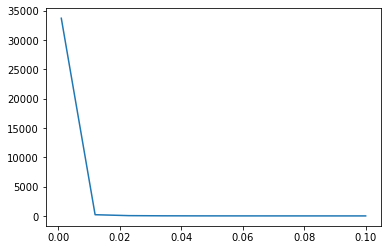

In [208]:
np.random.seed(5)
a1 = np.random.rand(100)
a2 = np.random.rand(100)

# Constructing the Hamiltonian
Ham = transform_to_jw_basis(make_anderson_model(1, 1/2, [1, 2, 3, 4], [-2, -1, 1, 2]))
for term in Ham.terms:
    if np.imag(term.coeff) != 0:
        raise ValueError("Hamiltonian has complex coefficient")
    term.coeff = np.real(term.coeff)



#Ham = Observable(10, pauli_terms=[Term(-0.5, "Z", [i]) for i in range(10)], constant_coeff=10/2)
    
ldt = np.linspace(1e-3, 1e-1, 10)
leps = []

for dt in ldt:
    leps.append(epsilon0(a1, a2, Ham, 1, 0, 10, 5, dt))

plt.plot(ldt, leps)

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$

$\newline$



# Distribution of states after the application of the HEA

Here we look at the distribution of states of $U(\theta)^\dagger U(\theta_0) | 0 \rangle$ for different $\theta_0$ and $\theta$.

We see that as the number of layers increase, the state $|0\rangle$ becomes less and less prefered until it has probability around $\frac 1 {2^n}$

We also check that the distribution of the basis states in the final state roughly correspond to the Porter-Thomas distribution.

Text(0.5, 1.0, '10 qubits and 30 layers')

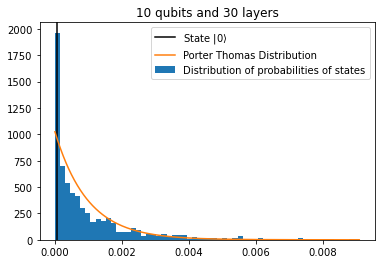

In [115]:
n_qubits = 10
n_layers = 30

#np.random.seed(0)

theta_0 = np.random.rand(1000)
theta = np.random.rand(1000)

qpu = get_default_qpu()

prog = Program()
reg = prog.qalloc(n_qubits)

U1 = HEA(n_qubits, n_layers, theta_0)
U2 = HEA(n_qubits, n_layers, theta)

U1(reg)
U2.dag()(reg)

circ = prog.to_circ()

job = circ.to_job(nbshots = 0)
res = qpu.submit(job)

# Probability of 0
prob0 = 0
for sample in res:
    if sample._state == 0:
        prob0 = sample.probability

plt.axvline(prob0, c = 'k', label = r'State $|0\rangle$')

# The histogram of probabilites
l = [sample.probability for sample in res]
plt.hist(l, bins = 60, density = True, label = 'Distribution of probabilities of states')

# The expected distribution
x = np.linspace(0, max(l), 1000)
plt.plot(x, 2**n_qubits * np.exp(- 2**n_qubits * x), label = "Porter Thomas Distribution")

plt.legend()
plt.title("10 qubits and 30 layers")

We look at what happens when $\theta$ is taken close to $\theta_0$. We take random $\theta$ with a normal distribution centered around $\theta_0$.

In [95]:
theta_0 = np.random.rand(1000)

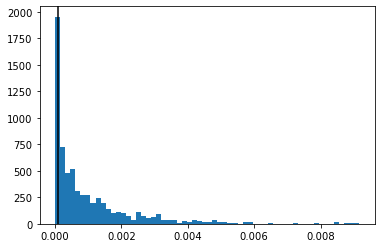

In [104]:
n_qubits = 10
n_layers = 30

#np.random.seed(0)
theta = theta_0 + np.random.normal(scale = 1, size = 1000)

qpu = get_default_qpu()

prog = Program()
reg = prog.qalloc(n_qubits)

U1 = HEA(n_qubits, n_layers, theta_0)
U2 = HEA(n_qubits, n_layers, theta)

U1(reg)
U2.dag()(reg)

circ = prog.to_circ()

job = circ.to_job(nbshots = 0)
res = qpu.submit(job)

# Probability of 0
prob0 = 0
for sample in res:
    if sample._state == 0:
        prob0 = sample.probability

plt.axvline(prob0, c = 'k')

# The histogram of probabilites
l = [sample.probability for sample in res]
plt.hist(l, bins = 60, density = True)

# The expected distribution
x = np.linspace(0, max(l), 1000)
#plt.plot(x, 2**n_qubits * np.exp(- 2**n_qubits * x))

For a given $\theta_0$ and a random $\theta$, we plot the probability of $|0\rangle$ as a function of the average distance between $\theta$ and $\theta_0$:
$$\frac 1 {len(\theta)} ||\theta - \theta_0||^2 $$

In [129]:
n_qubits = 10
n_layers = 20
theta_0 = np.random.rand(n_qubits + n_layers * (2 * n_qubits - 2))

Text(0, 0.5, 'Probability of $|0\\rangle$')

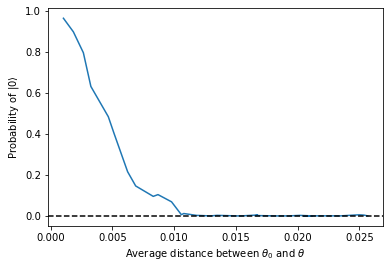

In [142]:
ld = []
lprob = []

#np.random.seed(0)
for sigma in np.linspace(0.02, 0.5, 30):
    
    theta = theta_0 + np.random.normal(scale = sigma, size = n_qubits + n_layers * (2 * n_qubits - 2))

    qpu = get_default_qpu()

    prog = Program()
    reg = prog.qalloc(n_qubits)

    U1 = HEA(n_qubits, n_layers, theta_0)
    U2 = HEA(n_qubits, n_layers, theta)

    U1(reg)
    U2.dag()(reg)

    circ = prog.to_circ()

    job = circ.to_job(nbshots = 0)
    res = qpu.submit(job)

    # Probability of 0
    prob0 = 0
    for sample in res:
        if sample._state == 0:
            prob0 = sample.probability
    
    ld.append(np.linalg.norm(theta - theta_0) / (n_qubits + n_layers * (2 * n_qubits - 2)))
    lprob.append(prob0)

plt.plot(ld, lprob)
plt.axhline(1 / 2**n_qubits, c = 'k', ls = '--')
plt.xlabel(r"Average distance between $\theta_0$ and $\theta$")
plt.ylabel(r"Probability of $|0\rangle$")
print()

# VQE on $\epsilon_1$

We take some random $\theta_0$ and an infinite number of shots, and we try to obtain a $\theta$ such that $\epsilon_1(\theta)$ is exactly 0.

In [342]:
np.random.seed(0)

n_qubits = 2
n_layers = 1
nb_shots = 1000

n_theta = n_qubits + n_layers * (2 * n_qubits - 2)

theta_0 = np.random.rand(n_theta)

l_theta = []

theta_1 = np.random.rand(n_theta)
theta_1 = np.random.rand(n_theta)

def callback(x):
    l_theta.append(x)

res = minimize(epsilon12, np.zeros(n_theta), args = (theta_0, nb_shots, n_qubits, n_layers), callback = callback, method = "Powell")

In [343]:
res

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.35456790e-07,  1.65164338e-07,  7.26561194e-19,
        -9.37151559e-10]])
     fun: array(0)
 message: 'Optimization terminated successfully.'
    nfev: 192
     nit: 2
  status: 0
 success: True
       x: array([-2.12244746,  4.64271581, -0.25649759, -0.04639882])

In [344]:
l_theta

[array([-2.12244697e+00,  2.58792896e+00,  1.13843507e-11, -1.46840516e-02]),
 array([-2.12244746,  4.64271581, -0.25649759, -0.04639882])]

Number of iterations: 2

Final value: 7.507675886331806e-07



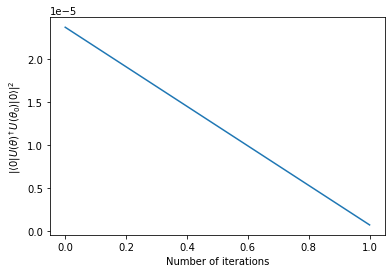

In [345]:
l_val = [epsilon12(theta, theta_0, 0, n_qubits, n_layers) for theta in l_theta]

plt.plot(l_val)
plt.xlabel("Number of iterations")
plt.ylabel(r"$| \langle 0 | U(\theta)^\dagger U(\theta_0) | 0 \rangle |^2$")

print("Number of iterations: " + str(len(l_val)))
print("\nFinal value: {}\n".format(l_val[-1]))